<a href="https://colab.research.google.com/github/alxhoff/TinyML-MNIST-model/blob/master/STM32F4_TFlite_MNIST_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example will perform character recognition through user input into the touch screen of an STM3240G-Evaluation board using the MNIST dataset.

In [20]:
#%tensorflow_version 2.x
!apt-get install -y xxd

#! pip uninstall -y tensorflow
#! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization

import tensorflow as tf
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = tf.keras.datasets.mnist.load_data()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.0.1453-1ubuntu1.3).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


Importing Tensorflow allows you to use its API to load the MNIST dataset. It should be noted that we need to use TF version <1.14 as this version includes the fully connected operation version 3 which is incompatible with the micro interpreters version 2.

3


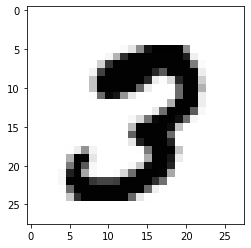

In [21]:
import matplotlib.pyplot as plt
test_index = 12345
print(labels_train[test_index])
plt.imshow(images_train[test_index], cmap='Greys')

The input of the neural network needs to know the input shape that it is going to be fed

In [22]:
input_shape = images_train.shape
print("{} images, each with shape of {} pixels x {} pixels".format(input_shape[0], input_shape[1], input_shape[2]))

60000 images, each with shape of 28 pixels x 28 pixels


The input shape for the model must be reshaped to 4D as the current shape does not show that each pixel is a 1D array where only the greyscale value (0-255) is stored. The input tensor's shape will be 3D as it will take a single-channel image. 

In [23]:
images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1)
images_test = images_test.reshape(images_test.shape[0], images_test.shape[1], images_test.shape[2], 1)
input_tensor_shape = (images_test.shape[1], images_test.shape[2], 1)
print("Input shape: {}".format(input_shape))

Input shape: (60000, 28, 28)


The greyscale values stores in the images' pixels are 8 bit values and need to be normalized into floats between 0-1.

In [0]:
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255

Now the convolutional NN that we will use to classify the input images taken from the touch screen will have the following layer structure

1. Conv2D
2. MaxPooling2D
3. Flatten
4. Dense
5. Dropout
11. Dense



In [0]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

model = keras.Sequential()

model.add(keras.layers.Conv2D(28, kernel_size=(3,3), input_shape=input_tensor_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(12, kernel_size=(3,3), input_shape=input_tensor_shape))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model2.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model3 = keras.Sequential()

model3.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model3.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
model3.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model3.add(keras.layers.Reshape((192,1)))
model3.add(keras.layers.MaxPooling1D(pool_size=6, padding='valid', data_format='channels_last'))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model4 = keras.Sequential()

model4.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model4.add(keras.layers.Reshape( (13, 13, 12, 1)))
model4.add(keras.layers.MaxPooling3D(pool_size=(6, 3,3)))
model4.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model4.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model5 = keras.Sequential()

model5.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model5.add(keras.layers.Reshape( (338, 6, 1)))
model5.add(keras.layers.MaxPooling2D(pool_size=(26, 3)))
model5.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model5.add(keras.layers.Dense(10,activation=tf.nn.softmax))

quantized_model5 = quantize_model(model5)

The Conv2D layer extracts features from the input image using filters that slide across the input image. In this case we will use 28 different filters to extract a large number of unique features that will then be used to classify each image in the later layers. Thus the output of this layer will have the shape (28, 28, 1, 28)

MaxPooling2D is used to reduce the output size of the convolutional layer by reducing each 2 x 2 unique chunk of the output down in to a singular value, this reducing the output's size by a factor of 4. This will reduce our (28, 28, 1, 28) tensor down to a (7, 7, 1, 28) tensor.

The Flatten layer then takes this 2D array (our image) and shapes it into a single dimension (1372).

The following Dense layer reduces the input 1372 values down into 128 classes, taking the first steps in classifying the image into on of the 10 output classes (0-9). This is done using the relu activation function.

The Dropout layer sets 20% of the tensor's values to 0 so as to reduce overfitting.

Finally the last Dense layer reduces the output value down to the 10 classes, each representing a digit between 0 and 9. This is done using the softmax activation function which makes the outputs a set of probabilities summing to 1.


Train the model

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

quantized_model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 10

print("Model 1")
history = model.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model.summary()

print("Model 2")
history2 = model2.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model2.summary()

print("Model 3")
history3 = model3.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model3.summary()

print("Model 4")
history4 = model4.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model4.summary()

print("Model 5")
history5 = model5.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model5.summary()

print("Model 5 Quantized")
history5_q = quantized_model5.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
quantized_model5.summary()


Model 1
Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 0.2621 - accuracy: 0.9234
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.1005 - accuracy: 0.9701
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0690 - accuracy: 0.9793
Epoch 4/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0524 - accuracy: 0.9837
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0432 - accuracy: 0.9863
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0349 - accuracy: 0.9884
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0295 - accuracy: 0.9904
Epoch 8/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0245 - accuracy: 0.9918
Epoch 9/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0208 - accuracy: 0.9932
Epoch 10/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0196 - accuracy

Now we can evaluate our trained model using the test data

In [27]:
res = model.evaluate(images_test, labels_test)
print("Model1 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model2.evaluate(images_test, labels_test)
print("Model2 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model3.evaluate(images_test, labels_test)
print("Model3 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model4.evaluate(images_test, labels_test)
print("Model4 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model5.evaluate(images_test, labels_test)
print("Model5 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = quantized_model5.evaluate(images_test, labels_test)
print("Quantized model5 has an accuracy of {0:.2f}%".format(res[1] * 100))


313/313 [==============================] - 1s 3ms/step - loss: 0.0496 - accuracy: 0.9860
Model1 has an accuracy of 98.60%
313/313 [==============================] - 1s 3ms/step - loss: 0.0822 - accuracy: 0.9745
Model2 has an accuracy of 97.45%
313/313 [==============================] - 1s 3ms/step - loss: 0.3852 - accuracy: 0.8783
Model3 has an accuracy of 87.83%
313/313 [==============================] - 1s 3ms/step - loss: 0.5035 - accuracy: 0.8375
Model4 has an accuracy of 83.75%
313/313 [==============================] - 1s 3ms/step - loss: 0.5959 - accuracy: 0.8236
Model5 has an accuracy of 82.36%
313/313 [==============================] - 1s 3ms/step - loss: 0.6610 - accuracy: 0.8011
Quantized model5 has an accuracy of 80.11%


In [0]:
#best_model = quantized_model5
best_model = model3

Now we will need to convert and save our model into a downloadable file that will be appropriate for a microcontroller. This is done using the TensorFlow Lite Converter. The `TFLITE_BUILTINS` option tells the converter to only use TensorFlow Lite built in operations.

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

open("MNIST_model_no_optimizations.tflite", "wb").write(tflite_model)
!xxd -i MNIST_model_no_optimizations.tflite > MNIST_model_no_optimizations.cc


Now we will be running this model on a constrained device and as such we will need to perform quantization and optimizations to reduce the size of the model. The optimizations that TensorFlow offers are detailed [here](https://www.tensorflow.org/lite/performance/model_optimization). Also see [here](https://www.tensorflow.org/model_optimization/guide/quantization/training) for more information on quanitazation aware training and [here](https://www.tensorflow.org/lite/performance/post_training_quantization) for information on post-training quantization.

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("MNIST_optimized_for_size.tflite", "wb").write(tflite_model)
!xxd -i MNIST_optimized_for_size.tflite > MNIST_optimized_for_size.cc

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("MNIST_default_optimizations.tflite", "wb").write(tflite_model)
!xxd -i MNIST_default_optimizations.tflite > MNIST_default_optimizations.cc

These optimizations reduced the file size significantly but we can do better. Enforcing full integer quantization for all operations as well as ensuring all model math is quantized to 8-bit. Doing so requires a representative dataset that can be used to evaluate optimizations made by the converter. The representative dataset must be a python iterator.


In [0]:
import numpy as np

def representative_dataset_gen():
  for image in images_test:
    array = np.array(image)
    array = np.expand_dims(array, axis = 0)
    yield ([array])

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

open("MNIST_full_quanitization.tflite", "wb").write(tflite_model)
!xxd -i MNIST_full_quanitization.tflite > MNIST_full_quanitization.cc

This file needs to now be included in our microcontroller project and as such must be in a form that is easily usable on a device without a file system. xxd can be used to convert the model into a C source file where the model is stored as a byte array.

In [32]:
!xxd -i MNIST_full_quanitization.tflite > MNIST_full_quanitization.cc
!cat MNIST_full_quanitization.cc

unsigned char MNIST_full_quanitization_tflite[] = {
  0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x4a, 0xfc, 0xff, 0xff,
  0x03, 0x00, 0x00, 0x00, 0xac, 0x10, 0x00, 0x00, 0xa0, 0x03, 0x00, 0x00,
  0x88, 0x03, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x78, 0x03, 0x00, 0x00, 0x64, 0x03, 0x00, 0x00, 0x28, 0x03, 0x00, 0x00,
  0x04, 0x03, 0x00, 0x00, 0xe0, 0x02, 0x00, 0x00, 0xcc, 0x02, 0x00, 0x00,
  0x78, 0x01, 0x00, 0x00, 0xf4, 0x00, 0x00, 0x00, 0xb0, 0x00, 0x00, 0x00,
  0xa4, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00,
  0x68, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x04, 0xf1, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x14, 0xf1, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x24, 0xf1, 0xff, 0xff,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00

This file is downloadable from the left hand menu of colab. Although this file is too large to be used as a model on a microcontroller. We will have to do some more optimizations.

Pruning is where unncessart values in weight tensors are removed, thus reducing the number of parameters needed to store the model. This is done by further training the model while intermittently running pruning code that removes unnecessary connections between the layers of the neuran network.

In [33]:
!pip install -q tensorflow-model-optimization

import numpy as np 
import os
from tensorflow_model_optimization.sparsity import keras as sparsity

end_step = np.ceil(1.0 * images_train.shape[0] / batch_size).astype(np.int32) * epochs
print(end_step)

pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.5,
                                                 final_sparsity=0.9,
                                                 begin_step=0,
                                                 end_step=end_step,
                                                 frequency=100
                                                 )
}

new_pruned_model = sparsity.prune_low_magnitude(best_model, **pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [sparsity.UpdatePruningStep(),sparsity.PruningSummaries(log_dir=os.path.abspath(os.getcwd()), profile_batch=0)]

new_pruned_model.fit(images_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     callbacks=callbacks)

score = new_pruned_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

6000
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_7 (None, 13, 13, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 4, 4, 12)          1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 192)               1         
_________________________________________________________________
prune_low_magnitude_reshape_ (None, 192, 1)            1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 32, 1)             1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 32)                1         
_________________________________________________________________
prune_low_magnitude_dense_9  (None, 10)          

Now we can export the pruned model

In [34]:
new_pruned_model.summary()
best_model_pruned = sparsity.strip_pruning(new_pruned_model)
best_model_pruned.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_7 (None, 13, 13, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 4, 4, 12)          1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 192)               1         
_________________________________________________________________
prune_low_magnitude_reshape_ (None, 192, 1)            1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 32, 1)             1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 32)                1         
_________________________________________________________________
prune_low_magnitude_dense_9  (None, 10)               

We can compare each pruned weight against zero to see how many weights were pruned out of the model

In [35]:
from tensorflow.keras.models import load_model

import numpy as np

for i, w in enumerate(best_model_pruned.get_weights()):
    print("{} -- Total:{}, Zeros: {:.2f}%".format(
        model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100 ))

conv2d_5/kernel:0 -- Total:108, Zeros: 89.81%
conv2d_5/bias:0 -- Total:12, Zeros: 0.00%
dense_6/kernel:0 -- Total:320, Zeros: 90.00%
dense_6/bias:0 -- Total:10, Zeros: 0.00%


Same as before we can quantize the model, convert and save

In [0]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(best_model_pruned)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

# Save the model to disk
open("MNIST_pruned.tflite", "wb").write(tflite_model)
!xxd -i MNIST_pruned.tflite > MNIST_pruned.cc

Puning saved us

In [37]:
print("Quanized file size difference is: {} bytes".format(os.path.getsize("MNIST_model_no_optimizations.tflite") - os.path.getsize("MNIST_full_quanitization.tflite")))
print("Pruned file size difference is: {} bytes".format(os.path.getsize("MNIST_full_quanitization.tflite") - os.path.getsize("MNIST_pruned.tflite")))

Quanized file size difference is: -236 bytes
Pruned file size difference is: 0 bytes


As the generated models are so large we need to make sure they are stored in the .rodata segment. To do so the model must be prefixed extern const such that it does not land in the .data segment and kill our ram. 

In [0]:
!sed -i '1s/^/extern const /' MNIST_full_quanitization.cc
!sed -i '$s/^/extern const /' MNIST_full_quanitization.cc